In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import geotorch

DEVICE = None
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.utils import *
from src.train import train
from src.plotters import Plotter
from src.costs import *

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_", mode="offline")

In [4]:
def run_experiment(source, target, cost, n_iter, *,
                   logger=None, **kwargs):
    if logger: logger.start()
    mover_copy = deepcopy(mover)
    critic_copy = deepcopy(critic)
    try:
        train(source, target, mover_copy, critic_copy, cost,
              n_iter=n_iter,
              logger=logger,
              **kwargs)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()
    return mover_copy, critic_copy

## GMM

### 3D to 2D

In [5]:
n_components = 10

locs_3d = 2 * fibonacci_sphere(n_components)
scales_3d = .1 * torch.ones_like(locs_3d)
source = GaussianMixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .1 * torch.ones_like(locs_2d)
target = GaussianMixture(locs_2d, scales_2d)

In [6]:
p, q = source.event_shape.numel(), target.event_shape.numel()
n_neurons = 64

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Output()

  0%|          | 0/500 [00:00<?, ?it/s]

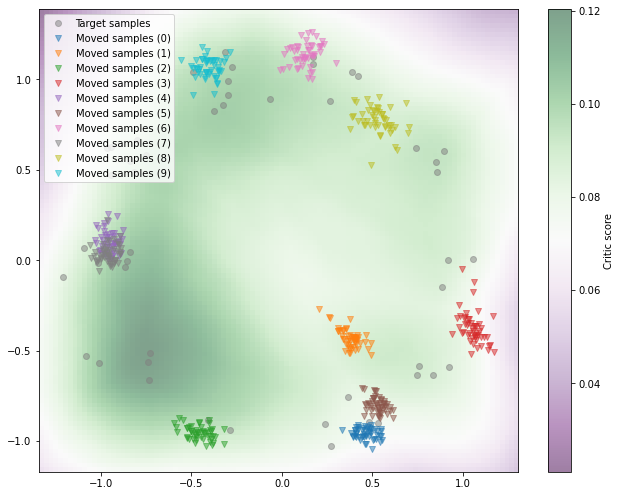

cost,█▇▅▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂
loss,█▇▅▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
cost,0.01899
loss,0.0232


In [7]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=Plotter(),
    logger=wandb_logger
)

In [22]:
n_components = 5

locs_3d = fibonacci_sphere(n_components)
scales_3d = .3 * torch.ones_like(locs_3d)
source = GaussianMixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .3 * torch.ones_like(locs_2d)
target = GaussianMixture(locs_2d, scales_2d)


In [23]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=Plotter(),
    logger=wandb_logger
)

NameError: name 'SimplePlotter' is not defined

In [15]:
n_components = 10

locs_3d = fibonacci_sphere(n_components)
scales_3d = .15 * torch.ones_like(locs_3d)
source = GaussianMixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .15 * torch.ones_like(locs_2d)
target = GaussianMixture(locs_2d, scales_2d)

In [17]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=Plotter(),
    logger=wandb_logger
)

NameError: name 'train' is not defined

In [7]:
n_components = 10

locs_3d = fibonacci_sphere(n_components)
scales_3d = .3 * torch.ones(n_components, p)
source = GaussianMixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .3 * torch.ones(n_components, q)
target = GaussianMixture(locs_2d, scales_2d)

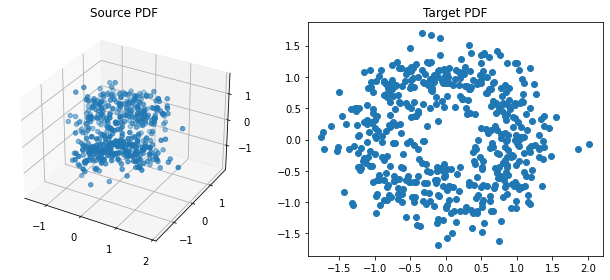

Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
solver = run_experiment(
    source, target,
    n_iter=1000,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=3,
        target_dim=2,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)

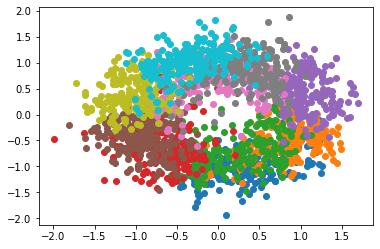

In [12]:
samples_3d = sample_from_gmm_components(source, (200,))

with torch.no_grad():
    moved_samples = solver.mover(samples_3d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

### 2D to 3D

In [8]:
p, q = 2, 3
n_neurons = 64

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [9]:
n_components = 7

locs_2d = uniform_circle(n_components)
scales_2d = .02 * torch.ones_like(locs_2d)
source = GaussianMixture(locs_2d, scales_2d)

locs_3d = fibonacci_sphere(n_components)
scales_3d = .02 * torch.ones_like(locs_3d)
target = GaussianMixture(locs_3d, scales_3d)


Output()

  0%|          | 0/500 [00:00<?, ?it/s]

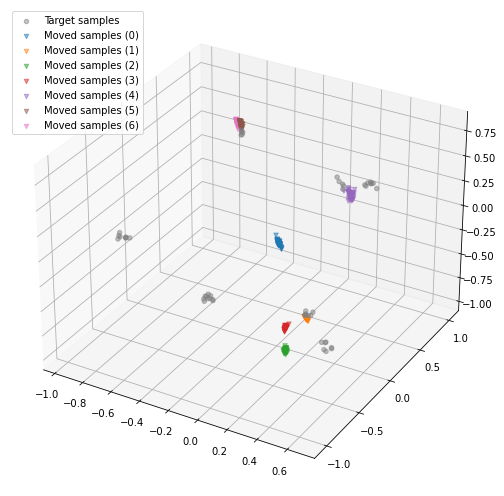

In [21]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=Plotter(),
#     logger=wandb_logger
)

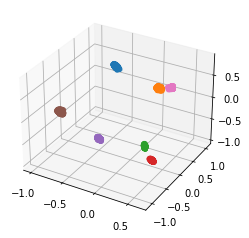

In [15]:
samples_2d = sample_from_gmm_components(source, (5000,))

with torch.no_grad():
    moved_samples = solver.mover(samples_2d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [7]:
n_components = 7

locs_2d = uniform_circle(2 * n_components)
scales_2d = .2 * torch.ones(2 * n_components, p)
source = GaussianMixture(locs_2d, scales_2d)

locs_3d = fibonacci_sphere(n_components)
scales_3d = .2 * torch.ones(n_components, q)
target = GaussianMixture(locs_3d, scales_3d)


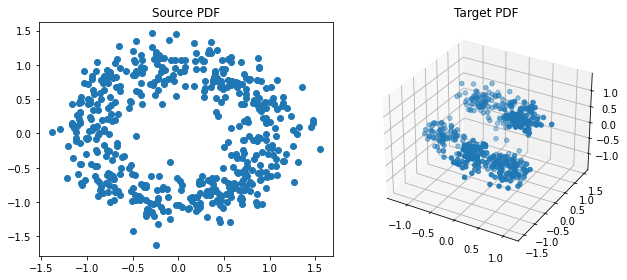

Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

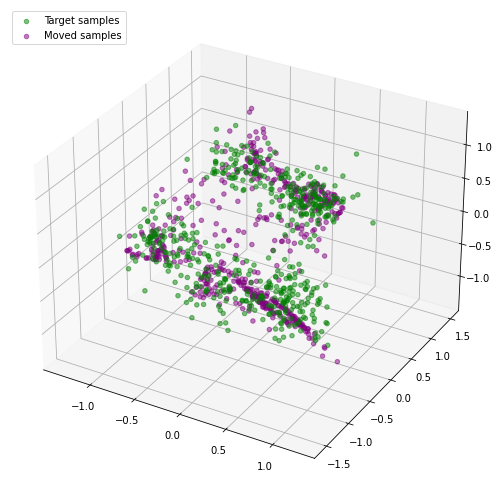

In [9]:
solver = run_experiment(
    source, target,
    n_iter=2000,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
    # show_progress=False
    ),
    n_inner_iter=5
)

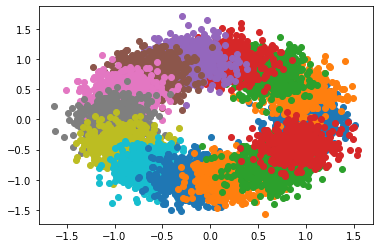

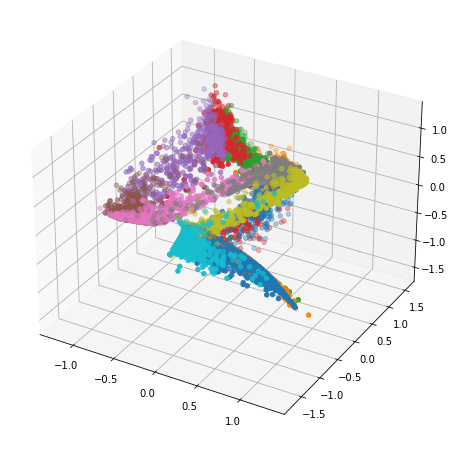

In [10]:
samples_2d = sample_from_gmm_components(source, (500,))

for samples_batch in samples_2d:
    plot_samples(samples_batch)
plt.show()

with torch.no_grad():
    moved_samples = solver.mover(samples_2d)

plt.figure(figsize=(10, 8))
for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [11]:
p = q = 2
n_neurons = 256

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [12]:
source = CurveDistribution(LineCurve(start=(-2, 0), end=(2, 0)))
target = Normal(torch.zeros(2), torch.ones(2))

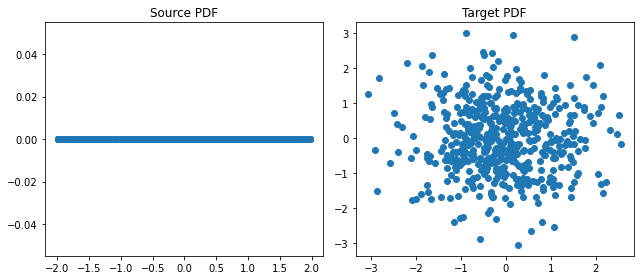

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
solver = run_experiment(
    source, target,
    n_iter=5000,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)